# Zillow and Building Footprint Data, Merge

The following notebook contains code to combine Zillow housing data (which contains coordinate points associated with housing information, such as residence type) with MS Building Footprint data.

It also experiments with viewing building footprints within a single census tract, in LA.

## Load in both data sets, cropping to LA

In [1]:
# Load necessary libraries
import os 
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import box

import matplotlib.pyplot as plt

In [2]:
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

In [32]:
# set option to see all data frame columns
pd.set_option('display.max_columns', None)

### Zillow Data

In [3]:
# read in the zillow geo data (takes about 10 minutes)
fp = os.path.join('data', 'final_zillow.gpkg')
zillow = gpd.read_file(fp)

In [4]:
# change CRS to standard
zillow = zillow.to_crs("EPSG:4326")

# take a look at geodf
zillow.head()

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,geometry
0,Multi,2003.0,1.0,None,None,I,224.0,491943.0,living,1003.0,3,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
1,Multi,2003.0,1.0,None,None,None,224.0,240117.0,living,936.0,4,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
2,Multi,2003.0,1.0,None,None,I,224.0,261770.0,living,997.0,5,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
3,Multi,2003.0,1.0,None,None,None,224.0,223337.0,living,1002.0,6,06001403302,468,PGE/SCE,RR106,POINT (-122.26800 37.79429)
4,Multi,2003.0,1.0,None,None,None,224.0,241347.0,living,1003.0,7,06001403302,468,PGE/SCE,RR106,POINT (-122.26798 37.79406)


In [5]:
# create LA bbox
la_bbox = box(minx=-118.240125, miny=33.832560, maxx=-118.119275, maxy=33.907389)
la_bbox = gpd.GeoDataFrame(geometry=[la_bbox], crs=zillow.crs)

In [6]:
# clip zillow data to LA
zillow_la = gpd.clip(zillow, la_bbox)

# and check
zillow_la.head()

,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code,geometry
2224925,Single,NaN,2.0,elec,None,None,1.0,76051.0,living,1188.0,3426071,06037571102,1134,PGE/SCE,RR101,POINT (-118.11959 33.83261)
2224926,Single,NaN,3.0,elec,None,O,1.0,378880.0,living,1430.0,3426072,06037571102,1134,PGE/SCE,RR101,POINT (-118.11941 33.83261)
2224924,Single,NaN,2.0,elec,None,O,1.0,487639.0,living,936.0,3426070,06037571102,1134,PGE/SCE,RR101,POINT (-118.11977 33.83261)
2225118,Single,NaN,2.0,elec,None,O,1.0,339905.0,living,1360.0,3426264,06037571102,1134,PGE/SCE,RR101,POINT (-118.12125 33.83262)
2225117,Single,NaN,2.0,elec,None,O,1.0,79819.0,living,1048.0,3426263,06037571102,1134,PGE/SCE,RR101,POINT (-118.12143 33.83262)


### Building Footprint Data

In [7]:
## this step may take a few seconds ##

# specify tile download url; this url is for area containing Santa Barbara, CA
url = 'https://data.source.coop/tge-labs/globalbuildingatlas-lod1/w120_n35_w115_n30.parquet'

# read the parquet file into a DataFrame
building_pqt = pd.read_parquet(url)

In [8]:
# extract limit information from `bbox` column using shapely (also takes some time)
building_pqt["geometry"] = building_pqt["bbox"].apply(
    lambda b: box(b["xmin"], b["ymin"], b["xmax"], b["ymax"])
)

In [9]:
# convert dataframe to a geopandas object
building = gpd.GeoDataFrame(building_pqt, geometry="geometry", crs="EPSG:4326")

# confirm transformation worked and we have a geodataframe
building.head()

,source,id,height,var,region,bbox,geometry
0,google,85462X6M+6P29,0.593977,0.266378,MEX,"{'xmin': -115.01574894346501, 'ymin': 32.01048...","POLYGON ((-115.01570 32.01049, -115.01570 32.0..."
1,google,85462XJC+97CF,1.242497,0.375091,MEX,"{'xmin': -115.02951566605297, 'ymin': 32.03090...","POLYGON ((-115.02921 32.03090, -115.02921 32.0..."
2,google,85462XJC+93WR,3.569647,0.333383,MEX,"{'xmin': -115.029850167836, 'ymin': 32.0309691...","POLYGON ((-115.02977 32.03097, -115.02977 32.0..."
3,google,85462XJC+C3MX,3.547499,0.278828,MEX,"{'xmin': -115.029862555864, 'ymin': 32.0310179...","POLYGON ((-115.02977 32.03102, -115.02977 32.0..."
4,google,85462XJC+G248,1.096296,0.098254,MEX,"{'xmin': -115.03003018059, 'ymin': 32.03120930...","POLYGON ((-115.02980 32.03121, -115.02980 32.0..."


In [10]:
# clip data frame to LA using same bbox as before
building_la = gpd.clip(building, la_bbox)

## Pre-Join Checks

In [11]:
# same CRS
assert building_la.crs == zillow_la.crs

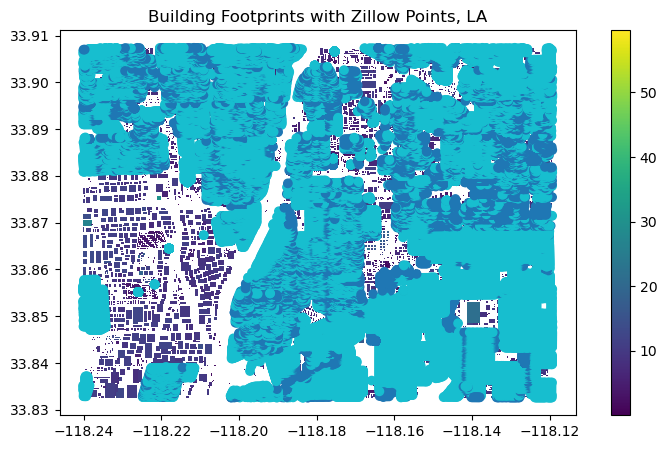

In [12]:
# preliminary plot

# initialize plot
fig, ax = plt.subplots(figsize=(9,5), nrows = 1, ncols = 1)

# plot building polygons
building_la.plot(ax = ax,
        column = 'height',
        legend = True)

# plot zillow points
zillow_la.plot(ax = ax,
               column = 'type')

plt.title("Building Footprints with Zillow Points, LA")
plt.show()

## Join Footprint Data onto Zillow

The spatial join will be done in this order because:
- the Zillow data corresponds only to residential buildings
- whereas the building footprints correspond to *all* buildings in LA, regardless of purpose
- we are only interested in residential units

The output of the spatial join should be a geodataframe that contains building polygons with zillow variables (like building type) associated with them.

In [33]:
zillow_building_la = gpd.sjoin(
    building_la,
    zillow_la,
    how = "inner",
    predicate = "intersects"
)

zillow_building_la.head()

,source,id,height,var,region,bbox,geometry,index_right,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code
4271289,ms,UnitedStates_023012311_1014874,3.834103,0.289709,USA,"{'xmin': -118.16961233227667, 'ymin': 33.83422...","POLYGON ((-118.16961 33.83422, -118.16961 33.8...",2200353,Single,NaN,3.0,fossil,central,I,1.0,389405.0,living,1908.0,3400206,06037571504,1234,PGE/SCE,RR101
4271253,ms,UnitedStates_023012311_593206,3.343801,0.271143,USA,"{'xmin': -118.17150453330655, 'ymin': 33.83420...","POLYGON ((-118.17150 33.83421, -118.17150 33.8...",2200436,Single,NaN,3.0,fossil,central,I,1.0,754611.0,living,2038.0,3400289,06037571504,1234,PGE/SCE,RR101
4271260,ms,UnitedStates_023012311_865581,4.831909,0.590572,USA,"{'xmin': -118.17047953605653, 'ymin': 33.83423...","POLYGON ((-118.17048 33.83424, -118.17048 33.8...",2200396,Single,NaN,3.0,elec,None,O,1.0,406844.0,living,1380.0,3400249,06037571504,1234,PGE/SCE,RR101
4271258,ms,UnitedStates_023012311_629125,3.324939,0.420802,USA,"{'xmin': -118.17089785354115, 'ymin': 33.83436...","POLYGON ((-118.17090 33.83436, -118.17090 33.8...",2200380,Single,NaN,3.0,elec,None,O,1.0,297842.0,living,1367.0,3400233,06037571504,1234,PGE/SCE,RR101
4271287,ms,UnitedStates_023012311_955651,2.720818,0.678211,USA,"{'xmin': -118.16959961096346, 'ymin': 33.83436...","POLYGON ((-118.16960 33.83437, -118.16960 33.8...",2200354,Single,NaN,3.0,elec,None,O,1.0,275515.0,living,1589.0,3400207,06037571504,1234,PGE/SCE,RR101


Text(0.5, 1.0, 'Residential Buildings in LA, by Unit Type')

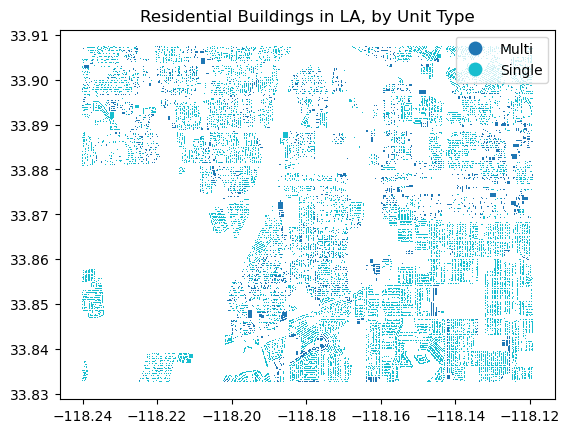

In [29]:
# Plot buildings with Zillow data, by type

zillow_building_la.plot(column = "type",
                       legend = True)

plt.title("Residential Buildings in LA, by Unit Type")

Text(0.5, 1.0, 'Residential Buildings in LA, by Number of Units')

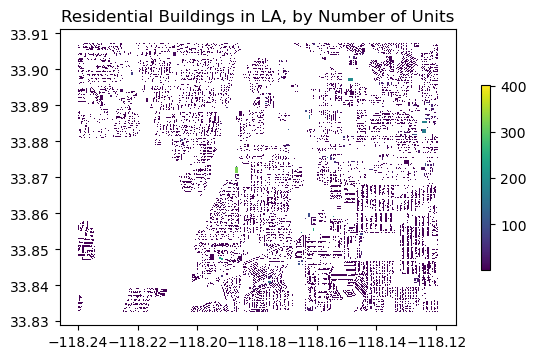

In [31]:
zillow_building_la.plot(column = "unit",
                        legend = True,
                       legend_kwds={'shrink': 0.5})

plt.title("Residential Buildings in LA, by Number of Units")

## Take Closer Look at Census Tract

Using census tract data from California, we can zoom in to have a better understanding of how to view residence type by building.

In [35]:
# load and view census tract data
ca_census = gpd.read_file("../../../../capstone/electrigrid/data/census/tl_2025_06_tract/tl_2025_06_tract.shp")

# set CRS to match other data
ca_census = ca_census.to_crs(zillow_building_la.crs)

ca_census.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,065,042516,06065042516,1400000US06065042516,425.16,Census Tract 425.16,G5020,S,973130,0,+33.9227363,-117.2393879,"POLYGON ((-117.24375 33.92818, -117.24323 33.9..."
1,06,065,042716,06065042716,1400000US06065042716,427.16,Census Tract 427.16,G5020,S,2698784,711913,+33.6865062,-117.2551285,"POLYGON ((-117.27209 33.68473, -117.27117 33.6..."
2,06,065,042717,06065042717,1400000US06065042717,427.17,Census Tract 427.17,G5020,S,6425166,145210,+33.6997108,-117.2534257,"POLYGON ((-117.26908 33.70438, -117.26882 33.7..."
3,06,065,042902,06065042902,1400000US06065042902,429.02,Census Tract 429.02,G5020,S,43393952,0,+33.7493422,-117.3068291,"POLYGON ((-117.34733 33.78247, -117.34731 33.7..."
4,06,065,042903,06065042903,1400000US06065042903,429.03,Census Tract 429.03,G5020,S,44642454,0,+33.8027798,-117.3133054,"POLYGON ((-117.36332 33.82940, -117.36331 33.8..."


In [42]:
## pick an arbitrary censs tract -- 06037571504 -- to take a closer look at 
# census data
census_1504 = ca_census[ca_census['GEOID'] == "06037571504"]
# zillow/building data
zillow_building_1504 = zillow_building_la[zillow_building_la['GEOID'] == "06037571504"]

zillow_building_1504.head(3)

,source,id,height,var,region,bbox,geometry,index_right,type,year,room,heat,cool,own,unit,value,sqft_type,sqft,ID,GEOID,p_ID,area,code
4271289,ms,UnitedStates_023012311_1014874,3.834103,0.289709,USA,"{'xmin': -118.16961233227667, 'ymin': 33.83422...","POLYGON ((-118.16961 33.83422, -118.16961 33.8...",2200353,Single,NaN,3.0,fossil,central,I,1.0,389405.0,living,1908.0,3400206,06037571504,1234,PGE/SCE,RR101
4271253,ms,UnitedStates_023012311_593206,3.343801,0.271143,USA,"{'xmin': -118.17150453330655, 'ymin': 33.83420...","POLYGON ((-118.17150 33.83421, -118.17150 33.8...",2200436,Single,NaN,3.0,fossil,central,I,1.0,754611.0,living,2038.0,3400289,06037571504,1234,PGE/SCE,RR101
4271260,ms,UnitedStates_023012311_865581,4.831909,0.590572,USA,"{'xmin': -118.17047953605653, 'ymin': 33.83423...","POLYGON ((-118.17048 33.83424, -118.17048 33.8...",2200396,Single,NaN,3.0,elec,None,O,1.0,406844.0,living,1380.0,3400249,06037571504,1234,PGE/SCE,RR101


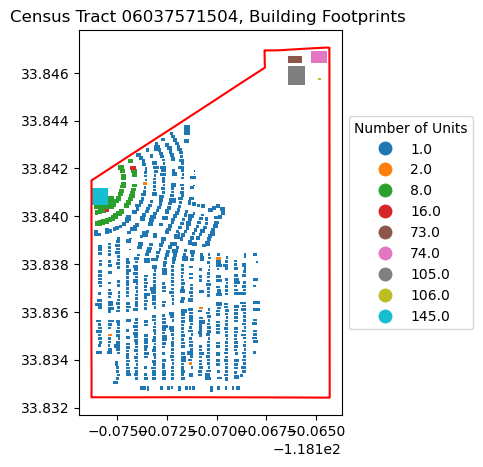

In [47]:
# Initialize plot with two axes, buildings and census tracts
fig, ax = plt.subplots(figsize=(9,5), nrows = 1, ncols = 1)

zillow_building_1504.plot(ax = ax,
        column = 'unit',
        legend = True,
        categorical = True,
        legend_kwds={'loc': 'center left', 'bbox_to_anchor': (1, 0.5), 'title': 'Number of Units'})

census_1504.boundary.plot(ax = ax,
                            color = "red")

plt.title("Census Tract 06037571504, Building Footprints ")
plt.show()

## Cleaning Combined Data Frame

Our cleaned data frame will contain only the necessary columns, listed below. We will accomplish this by:
1. Clipping building footprints just to the area of California (for computational speed)
2. Selecting only necessary columns in building data
3. Selecting only necessary columns in Zillow data
2. Combining Zillow and footprint data, just as we did before

For now, we will keep:

**Building:**
- height
- var
- geometry

**Zillow:**
- ID
- type
- room
- heat
- cool
- own * check metadata?
- unit
- value
- sqft_type
- sqft
- GEOID

<Axes: >

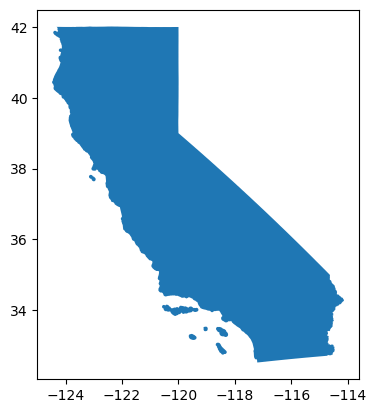

In [66]:
# load CA outline for clipping
fp = os.path.join('data', 'ca_state_boundary', 'CA_State.shp')
ca_boundary = gpd.read_file(fp)

# ensure same CRS as other data
ca_boundary = ca_boundary.to_crs(building.crs)

ca_boundary.plot()

In [89]:
# save bounding box from CA polygon (clipping to exact shape would take a very long time)
ca_bounds = [*ca_boundary.bounds.iloc[0]]
ca_bbox = box(*bounds_list)

[-124.48201686112381,
 32.528836736912375,
 -114.13122247472313,
 42.00952226962109]

In [93]:
# clip building data set to California (takes a few minutes)
building_ca = gpd.clip(building, ca_bbox)

In [94]:
# clean building_ca
building_ca_clean = building_ca[['height', 'var', 'region', 'geometry']]

building_ca_clean.head(3)

,height,var,region,geometry
562410,0.124859,0.011313,MEX,"POLYGON ((-115.51911 32.54054, -115.51911 32.5..."
562363,3.628849,0.717310,MEX,"POLYGON ((-115.51599 32.54466, -115.51599 32.5..."
562359,0.435984,0.042978,MEX,"POLYGON ((-115.51636 32.54483, -115.51636 32.5..."


In [98]:
# clean zillow
zillow_clean = zillow[['type','room','heat','cool', 'own', 'unit', 'value', 'sqft_type', 'sqft', 'GEOID', 'ID', 'geometry']]

zillow_clean.head(3)

,type,room,heat,cool,own,unit,value,sqft_type,sqft,GEOID,ID,geometry
0,Multi,1.0,None,None,I,224.0,491943.0,living,1003.0,06001403302,3,POINT (-122.26800 37.79429)
1,Multi,1.0,None,None,None,224.0,240117.0,living,936.0,06001403302,4,POINT (-122.26800 37.79429)
2,Multi,1.0,None,None,I,224.0,261770.0,living,997.0,06001403302,5,POINT (-122.26800 37.79429)


In [101]:
# combine the two clean data frames
zillow_building_ca = gpd.sjoin(
    building_ca_clean,
    zillow_clean,
    how = "inner",
    predicate = "intersects")

zillow_building_ca.head(3)

,height,var,region,geometry,index_right,type,room,heat,cool,own,unit,value,sqft_type,sqft,GEOID,ID
7029511,4.743917,0.886769,USA,"POLYGON ((-117.09581 32.56566, -117.09581 32.5...",7936689,Single,3.0,None,None,O,1.0,289974.0,living,1380.0,06073010104,8307781
7029512,3.584368,0.209780,USA,"POLYGON ((-117.09666 32.56567, -117.09666 32.5...",7936684,Single,4.0,None,None,O,1.0,285423.0,living,2187.0,06073010104,8307776
7029509,6.331801,1.570812,USA,"POLYGON ((-117.09598 32.56570, -117.09598 32.5...",7936688,Single,4.0,None,None,O,1.0,152338.0,living,1546.0,06073010104,8307780


We have achieved our clean data frame!